In [166]:
import os, sys, time
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas
import gzip
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch
sys.path.append("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/python_scripts/svcca")
import cca_core
from sklearn.cross_decomposition import CCA
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from datetime import datetime
sys.path.append("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/python_scripts/src")
from dim_redu_anns.utils import get_relevant_output_layers

In [118]:
def _plot_helper(arr, xlabel, ylabel):
    plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

In [119]:
print(layer_names)

['features.0', 'features.4', 'features.7', 'features.9', 'features.11', 'classifier.2', 'classifier.5']


In [120]:
imagenet_path = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_data/imagenet"
imagenet_val_path = os.path.join(imagenet_path, "val")
batch_size = 10
num_workers = 1
model_name = "alexnet"
layer_names = get_relevant_output_layers(model_name)
layer_idx = 0
target_layer = layer_names[layer_idx]
num_stim = 1000

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose(
    [       
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]           
)
loader = DataLoader(
    datasets.ImageFolder(imagenet_val_path, transform=transform),
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    timeout=100,
)  # shuffle=True, took out bc I want my feats aligned

model_cls = getattr(models, model_name)
model = model_cls(pretrained=True).to(device).eval()

feature_extractor = create_feature_extractor(
    model, return_nodes=[target_layer]
)


/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [126]:
def sample_features(loader, feature_extractor, layer_name, batch_size, num_stim, pooling="all"):
    if num_stim == 0:
        num_stim = len(loader.dataset)
    counter = 0
    all_feats = []
    for inputs, _ in loader:
        counter += 1
        if counter*batch_size > num_stim:
            break
        print(datetime.now().strftime("%H:%M:%S"), f"starting batch {counter}")
        with torch.no_grad():
            inputs = inputs.to(device)
            feats = feature_extractor(inputs)[target_layer]
            if pooling== "maxpool":
                if layer_name == 'avgpool' or 'classifier' in layer_name:
                    pass # don't do anything, it's already flat
                else:
                    feats = np.max(feats.cpu().numpy(), axis=(2,3)) # pools the max in the feats
            elif pooling== "avgpool":
                if layer_name == 'avgpool' or 'classifier' in layer_name:
                    pass # don't do anything, it's already flat
                else:
                    feats = np.mean(feats.cpu().numpy(), axis=(2,3)) # pools the max in the feats
            elif pooling == "all":
                feats = feats.view(feats.size(0), -1).cpu().numpy()
            all_feats.append(feats)
    return all_feats


In [141]:
feature_extractor2 = create_feature_extractor(
    model, return_nodes=[target_layer]
)
all_feats = sample_features(loader, feature_extractor2, target_layer, batch_size, 2000, "avgpool")

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


14:33:44 starting batch 1
14:33:44 starting batch 2
14:33:44 starting batch 3
14:33:44 starting batch 4
14:33:44 starting batch 5
14:33:44 starting batch 6
14:33:44 starting batch 7
14:33:44 starting batch 8
14:33:44 starting batch 9
14:33:44 starting batch 10
14:33:44 starting batch 11
14:33:44 starting batch 12
14:33:44 starting batch 13
14:33:44 starting batch 14
14:33:44 starting batch 15
14:33:44 starting batch 16
14:33:44 starting batch 17
14:33:44 starting batch 18
14:33:44 starting batch 19
14:33:44 starting batch 20
14:33:44 starting batch 21
14:33:44 starting batch 22
14:33:44 starting batch 23
14:33:44 starting batch 24
14:33:45 starting batch 25
14:33:45 starting batch 26
14:33:45 starting batch 27
14:33:45 starting batch 28
14:33:45 starting batch 29
14:33:45 starting batch 30
14:33:45 starting batch 31
14:33:45 starting batch 32
14:33:45 starting batch 33
14:33:45 starting batch 34
14:33:45 starting batch 35
14:33:45 starting batch 36
14:33:45 starting batch 37
14:33:45 s

In [142]:
all_acts = np.concatenate(all_feats, axis=0)

In [130]:
print(all_acts.shape)

(1000, 64)


In [143]:
# Toy Example of CCA in action

# assume X_fake has 100 neurons and we have their activations on 1000 datapoints
#A_fake = np.random.randn(100, 2000)
A_fake = all_acts[:,:20].T
# Y_fake has 50 neurons with activations on the same 1000 datapoints
# Note X and Y do *not* have to have the same number of neurons
#B_fake = np.random.randn(50, 2000)
B_fake =all_acts[:,20:50].T
# computing CCA simliarty between X_fake, Y_fake
# We expect similarity should be very low, because the fake activations are not correlated
results = cca_core.get_cca_similarity(A_fake, B_fake, verbose=True)


adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!


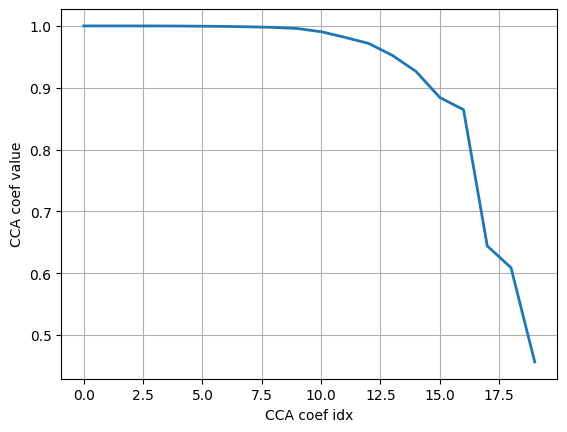

In [144]:
# correlation coefficients
_plot_helper(results["cca_coef1"], "CCA coef idx", "CCA coef value")

In [145]:
print("Single number for summarizing similarity")
print('{:.4f}'.format(np.mean(results["cca_coef1"])))

Single number for summarizing similarity
0.9136


This is a simple baseline we can compare other results to. As an example, let's see what the similarity looks like when we compare A to a scaled invertible transform of A. CCA is invariant to these, so we expect to see perfect CCA correlation.

In [146]:
At_fake = np.dot(np.random.randn(A_fake.shape[0], A_fake.shape[0]), A_fake)

results_t = cca_core.get_cca_similarity(A_fake, At_fake)

adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!


Single number for summarizing similarity
1.0000


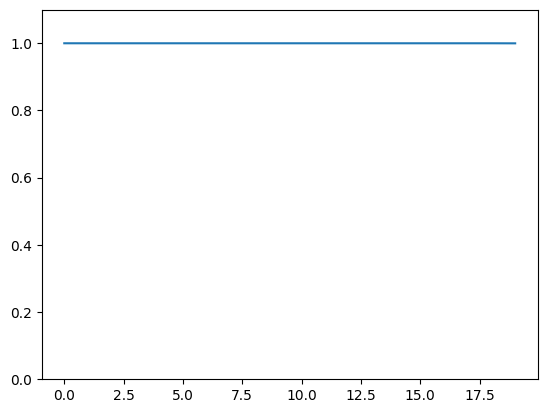

In [147]:
plt.plot(results_t["cca_coef1"])
plt.ylim((0,1.1))
print("Single number for summarizing similarity")
print('{:.4f}'.format(np.mean(results_t["cca_coef1"])))

In [148]:
A_fake.shape

(20, 2000)

In [162]:

cca = CCA(n_components = 20)
d1, d2 = cca.fit_transform(A_fake.T, B_fake.T)
print(d1.shape)
coefs_CCA = np.array([
    np.corrcoef(d1[:, i], d2[:, i])[0, 1] for i in range(d1.shape[1])
])
print(coefs_CCA, np.mean(coefs_CCA))

#print(np.corrcoef(d1.T,d2.T)[0:d1.shape[1], d1.shape[1]:]) # [:tot_dims, :tot_dims]

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


(2000, 20)
[0.99927344 0.99923326 0.99859957 0.99885055 0.9987418  0.99617797
 0.99953891 0.9998956  0.99073372 0.99996214 0.98152024 0.97174997
 0.95241488 0.99999958 0.9262869  0.88420022 0.8645814  0.64412953
 0.60899142 0.45655179] 0.9135716440018401


In [173]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

sresults = []
skresults = []
#num_datapoints = [101, 200, 500, 1000, 2000, 5000, 10000]
num_datapoints = [101,150, 200, 250, 300, 400, 500, 1000,1250, 1500, 1750, 2000]#, 2250, 2500, 3000, 4000, 5000]
gtime = []
sktime = []
eps = 10e-6
for nd in num_datapoints:
    #A_fake = np.random.randn(100, nd)
    #B_fake = np.random.randn(100, nd)
    Atest_fake = A_fake[:, :nd]
    Btest_fake = B_fake[:, :nd]
    #Atest_fake += eps * np.random.randn(*Atest_fake.shape)
    #Btest_fake += eps * np.random.randn(*Btest_fake.shape)
    start = time.time()
    results = cca_core.get_cca_similarity(Atest_fake, Btest_fake, verbose=False)
    end = time.time()
    gtime.append(end-start)
    #print(f"google {nd} samples - elapsed time: {end - start:.4f} seconds")
    sresults.append(np.mean(results["cca_coef1"]))
    start = time.time()
    d1, d2 = cca.fit_transform(Atest_fake.T, Btest_fake.T)
    end = time.time()
    sktime.append(end-start)
    #print(f"sklearn {nd} samples - elapsed time: {end - start:.4f} seconds")
    coefs_CCA = np.array([
    np.corrcoef(d1[:, i], d2[:, i])[0, 1] for i in range(d1.shape[1])
    ])
    skresults.append(np.mean(coefs_CCA))
    
#plt.plot(num_datapoints, sresults, lw=2.0)
#plt.plot(num_datapoints, gtime, lw=2.0)
#plt.grid()
#plt.title("google implementation")
#plt.xlabel("Num Datapoints")
#plt.ylabel("Mean CCA Correlation Coefficient")
#plt.figure()
#plt.plot(num_datapoints, skresults, lw=2.0)
#plt.plot(num_datapoints, sktime, lw=2.0)

#plt.grid()
#plt.title("sklearn implementation")
#plt.xlabel("Num Datapoints")
#plt.ylabel("Mean CCA Correlation Coefficient")
    

In [178]:


results = cca_core.get_cca_similarity(A_fake, B_fake, epsilon=1e-10, verbose=False)
print(A_fake.shape)    

(20, 2000)


Mean CCA similarity 0.9135614810703266


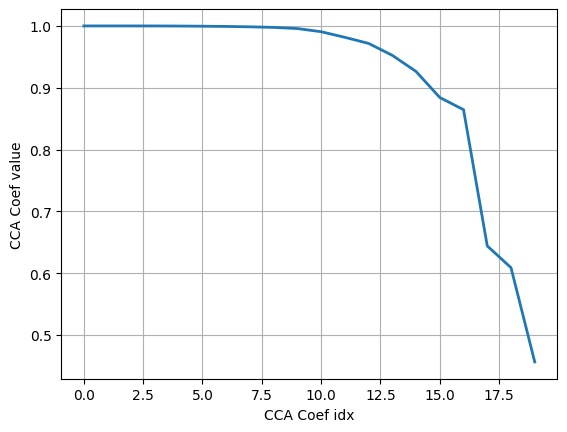

In [176]:
_plot_helper(results["cca_coef1"], "CCA Coef idx", "CCA Coef value")
print("Mean CCA similarity", np.mean(results["cca_coef1"]))

Just taking a mean similarity and looking at the plot seems to suggest that these two representations aren't that similar. But we have to be more careful here. Let's try doing an SVD over one of the set of activations to see how many large variance directions there are:

Fraction of variance explained by 20 singular vectors 1.0


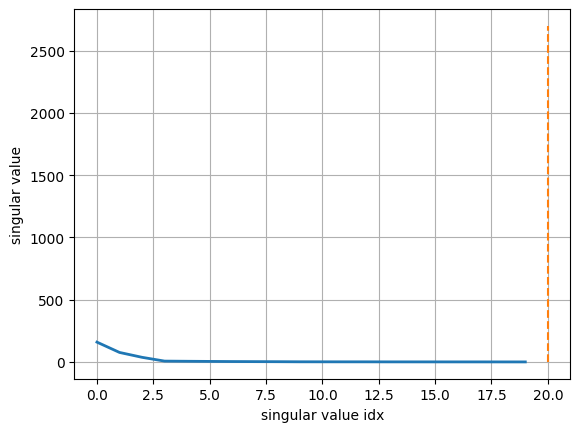

In [181]:
_, s, v = np.linalg.svd(A_fake - np.mean(A_fake, axis=1, keepdims=True), full_matrices=False)
_plot_helper(s, "singular value idx", "singular value")
#plt.plot([20]*100, np.linspace(0, 2700, 100), linestyle="--")
print("Fraction of variance explained by 20 singular vectors", np.sum(s[:20])/np.sum(s))

In [182]:
# creating a random baseline
b1 = np.random.randn(*A_fake.shape)
b2 = np.random.randn(*B_fake.shape)

Baseline Mean CCA similarity 0.11134270880036927
MNIST Mean CCA similarity 0.9135614810703266


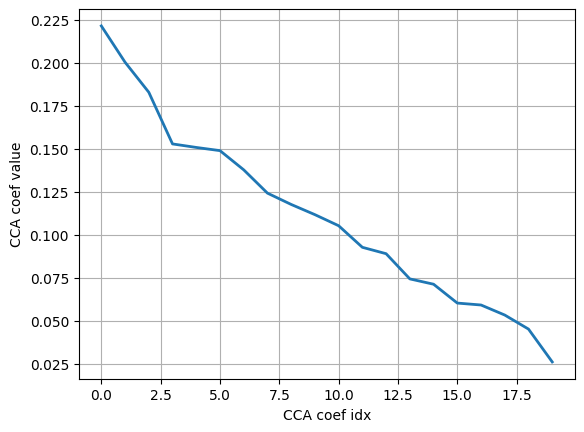

In [183]:
baseline = cca_core.get_cca_similarity(b1, b2, epsilon=1e-10, verbose=False)
_plot_helper(baseline["cca_coef1"], "CCA coef idx", "CCA coef value")
print("Baseline Mean CCA similarity", np.mean(baseline["cca_coef1"]))
print("MNIST Mean CCA similarity", np.mean(results["cca_coef1"]))

There's a clear difference between the baseline mean CCA similarity and the MNIST mean CCA similarity, but let's see if we can separate things further.

##### 1. Averaging Top CCA Values

In [184]:
# comparing different results
print("Results when averaging top CCA values")
print("Baseline", np.mean(baseline["cca_coef1"][:20]), "and MNIST", np.mean(results["cca_coef1"][:20]))

Results when averaging top CCA values
Baseline 0.11134270880036927 and MNIST 0.9135614810703266


##### 2. Using SVCCA

Results using SVCCA keeping 20 dims
Baseline 0.08466827031647804 and MNIST 0.8407138878428929


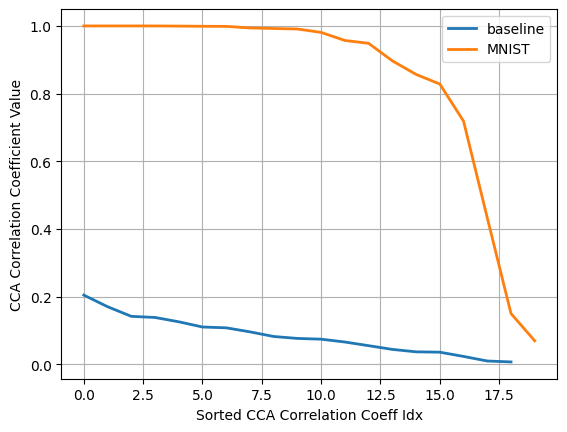

In [187]:
print("Results using SVCCA keeping 20 dims")

# Mean subtract activations
cacts1 = A_fake - np.mean(A_fake, axis=1, keepdims=True)
cacts2 = B_fake - np.mean(B_fake, axis=1, keepdims=True)

# Perform SVD
U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

svacts1 = np.dot(s1[:20]*np.eye(20), V1[:20])
# can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
svacts2 = np.dot(s2[:20]*np.eye(20), V2[:20])
# can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)

# Mean subtract baseline activations
cb1 = b1 - np.mean(b1, axis=0, keepdims=True)
cb2 = b2 - np.mean(b2, axis=0, keepdims=True)

# Perform SVD
Ub1, sb1, Vb1 = np.linalg.svd(cb1, full_matrices=False)
Ub2, sb2, Vb2 = np.linalg.svd(cb2, full_matrices=False)

svb1 = np.dot(sb1[:20]*np.eye(20), Vb1[:20])
svb2 = np.dot(sb2[:20]*np.eye(20), Vb2[:20])

svcca_baseline = cca_core.get_cca_similarity(svb1, svb2, epsilon=1e-10, verbose=False)
print("Baseline", np.mean(svcca_baseline["cca_coef1"]), "and MNIST", np.mean(svcca_results["cca_coef1"]))

plt.plot(svcca_baseline["cca_coef1"], lw=2.0, label="baseline")
plt.plot(svcca_results["cca_coef1"], lw=2.0, label="MNIST")
plt.xlabel("Sorted CCA Correlation Coeff Idx")
plt.ylabel("CCA Correlation Coefficient Value")
plt.legend(loc="best")
plt.grid()


##### 3. Using PWCCA

In [189]:
import pwcca
pwcca_mean, w, _ = pwcca.compute_pwcca(A_fake, B_fake, epsilon=1e-10)
pwcca_baseline, wb, _ = pwcca.compute_pwcca(b1, b2, epsilon=1e-10)
print("Results using PWCCA")
print("Baseline", pwcca_baseline, "and MNIST", pwcca_mean)

Results using PWCCA
Baseline 0.11220305795257995 and MNIST 0.9966831441985249
